<a href="https://colab.research.google.com/github/Ogunfool/Examining-the-effect-of-hyperparameters-and-Exploring-the-relationship-between-hyperparameters/blob/main/Building%2C_Training_and_Tuning_an_Image_Classification_Model_with_TensorFlow_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import necessary libraries.

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
# import torch 

In [ ]:
# !pip install matplotlib
import matplotlib.pyplot as plt

In [ ]:
from tensorflow import keras
from keras import losses, optimizers, layers, activations, regularizers

In [ ]:
# !pip install -q -U keras-tuner
import keras_tuner as kt

In [ ]:
!pip install git+https://github.com/tensorflow/docs

In [ ]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

# Tensorflow connection with GPU.

3 ways to check if tensorflow is connected to GPU on your device.

In [ ]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

In [ ]:
# !nvidia-smi

In [ ]:
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# Next, we'll confirm that we can connect to the GPU with tensorflow:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Download and prepare datasets for use in tensorflow.

Download and Prepare dataset - Data needs to be formatted as tf datasets for effective use in tensorflow.


*   Two(2) ways of loading image data and building image input pipeline is shown below.
1. Load image and build image input pipeline using the tf.keras.utils.image_dataset_from_directory() utility.
Calling the image_dataset_from_directory(main_directory) will return a tf.data.Dataset that yields batches of images, the supported image formats are: jpeg, png, bmp, gif. Animated gifs are truncated to the first frame.
2. Download the dataset from the large catalog available in TensorFlow Datasets, if the desired dataset is available (This might not always be the case because you would mostly work with new datasets in real world) but here - We chose this method because we are using the cifar10 dataset which would be used to experiment the effects of different hyperparameters is available in tensorflow datasets.







Method 1

In [ ]:
# Method 1
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)  # It downloads data from url if it is not already in cache
data_dir = pathlib.Path(archive).with_suffix('')

228813984/228813984 [==============================] - 8s 0us/step


In [ ]:
data_dir

PosixPath('/root/.keras/datasets/flower_photos')

In [ ]:
import os
import PIL
import PIL.Image
import tensorflow_datasets as tfds

3670


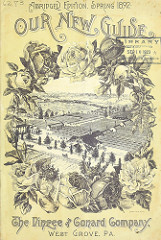

In [ ]:
# Now you have a copy of the images available in data_dir
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

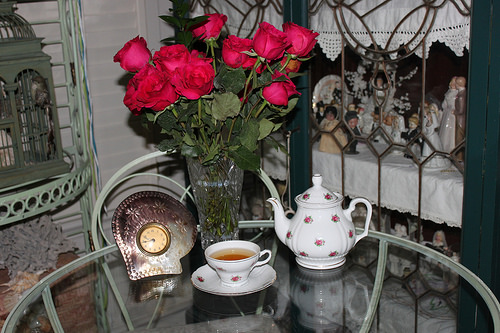

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
(32, 180, 180, 3)
(32,)


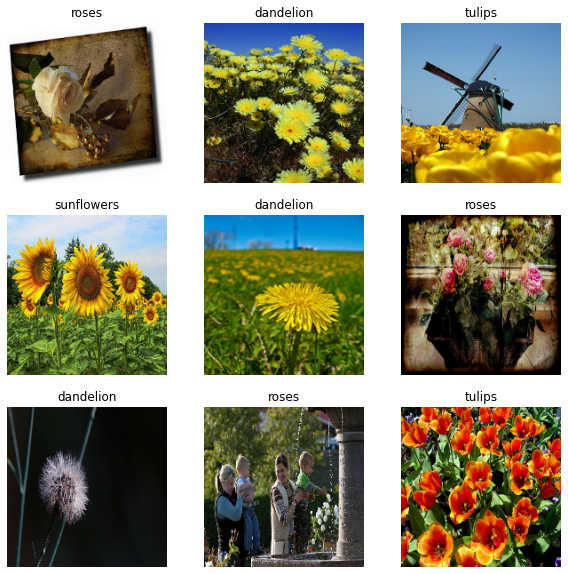

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

# Train dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Class Name Attribute of the dataset - You can find the class names in the class_names attribute on these datasets.
class_names = train_ds.class_names
print(class_names)

# Visualize dataset
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# You can manually iterate over the dataset and retrieve batches of images:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break
# You can call numpy() on these tensors(image_batch, labels_batch) to convert it into numpy.array()


Method 2

In [ ]:
# !pip install tensorflow-datasets

In [ ]:
# Load data using another method that doesn't involve having to use sklearn to split validation data
import tensorflow_datasets as tfds
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'cifar10',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

C:\Users\Oluwaseyi\anaconda3\envs\tf_gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# train_len = len(list(train_ds))
# Global Variables
batch_size = 192
# STEPS_PER_EPOCH = train_len/batch_size

CONFIGURING DATASET FOR PERFORMANCE.

1.   Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
2.  Dataset.prefetch overlaps data preprocessing and model execution while training.
Interested readers can learn more about both methods, as well as how to cache data to disk in the Prefetching section of the Better performance with the tf.data API guide.


In [ ]:
# Configure Dataset (cache, Shuffle, Batch and, prefetch)
AUTOTUNE = tf.data.AUTOTUNE

def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

# Plot an image
num_classes = metadata.features['label'].num_classes
print(num_classes)

get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))


train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

In [ ]:
train_ds

# Helper Functions: For compiling and fitting models and plotting learning curves.

Training and Validation Loss helper function

In [ ]:
# Let's create some helper functions for the training process (We are trying to select a model so, many models will be trained and they have similar execution configurations)
# Learning Rate Scheduler:
def lr_scheduler(STEPS_PER_EPOCH):
  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False)
  return lr_schedule

def get_optimizer(scheduler=None):
  if scheduler is None:
    return keras.optimizers.Adam(learning_rate=0.001)
  return keras.optimizers.Adam(lr_scheduler())

def get_callbacks():
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=40),
  ]

# Compile and fit
def compile_and_fit(model, optimizer=None, scheduler=None,  max_epochs=1000, STEPS_PER_EPOCH=1000):
  if optimizer is None:    # that is, i want to set Adam optimizer & learning rate to 0.001 by default or use a lr_scheduler function
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  # model.summary()
  history = model.fit(
    train_ds,
    epochs=max_epochs,
    validation_data=val_ds,
    # callbacks=get_callbacks(),
    verbose=0)
  
  return history


In [ ]:
# Helper function that plots, saves and shows plots
def plot_loss_accuracy(filename):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend(loc=0)
  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation accuracy')
  plt.legend(loc=0)
  plt.figure()

  plt.savefig(filename + '.png')
  plt.show()

# Choosing a baseline model. 

*   Keras preprocessing layers are used to include the image feature scaling layers to the model. With this you can easily build and export models that can accept raw images/data during test and perform desired feature scaling transformations on them and classify the images.

*   The baseline model is a chosen skeletal ntework architecture to be tuned. Choosing a baseline model is an effective approach to quickly and effectively minimize the hyperparameter space for deep neural networks. The hyperparameter space can quickly to grow to thousands which will make tuning a very daunting task. So it is advised to start somewhere, so the idea of choosing a baseline model is to start at a relatively good point and work our way up to getting a better model.
*   When choosing the baseline model, we are more concerned about the insample error and network architecture. It is advised by many renowned ML practitioners and researchers to start from a small, working model and work your way up. The baseline model can also be chosen from available network configurations, the field of computer vision has had many advances and there are available CNN architectures/models that can serve as a starting point for most classification problems e.g the RESNET or VGG model. in this notebook, we started from a small model and worked our way up to a variant of the VGG model which was chosen as the final baseline model that was tuned further.  

  Choosing: 
  1. The right network type for the dataset, e.g CNN or feed forward NN..
  For images, CNN is advised because it.....
  2. A good/desirable network size (No of layers, no of neurons, No of filters)
  1.   Watch out for less expressive models - Underfitting i.e. there is still room for improvement on the train data caused by a model not been powerful enough. Note: deep learning models tend to be good at fitting to the training data, but the real challenge is generalization, not learning due to overfitting.
  2.   Watch out for overly expressive models - When choosing the baseline model, we aren't too concerned about ovefitting yet but some models are too expressive and shouldn't be used as the baseline model as well. So choosing a baseline model is all about finding a balance between underfitting and overfitting. 
  Using early stopping is a quick and eficient approach for choosing baseline models, with early stopping, you can see how expressive the model is given how quickly overfitting occurs and validation accuracy at the end of training.




In [ ]:
# MODELS - Tiny, Small, Medium, Large
# Starting with the tiny model and babysitting it to get baseline model.
tiny_model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

# Tiny model with regularization
tiny_model_reg = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, activation='relu', kernel_regularizer=regularizers.L2(0.003)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

# Small model
small_model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

# Small model with weight regularization and dropout
small_model_reg = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu', kernel_regularizer=regularizers.L2(0.003)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(num_classes)
])

# Deeper Networks - More Conv layers
medium_model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

large_model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    # Note the input shape is the desired size of the image 32x32 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,3)), # output  channel size = 64, kernel size = 3,3
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

# Deeper Network -Baseline Model
b_model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    # Note the input shape is the desired size of the image 32x32 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,3), ), # output  channel size = 64, kernel size = 3,3
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),

    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),

     # The fifth convolution
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.L2(0.003)),
    # The sixth convolution
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.L2(0.003)),
    tf.keras.layers.MaxPooling2D(2,2),

    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 1024 neuron hidden layer
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    # Output layer
    tf.keras.layers.Dense(num_classes)
])

Highest validation accuracy: 0.5659999847412109
Best epoch: 4
Highest validation accuracy: 0.6575999855995178
Best epoch: 10
Highest validation accuracy: 0.6877999901771545
Best epoch: 30
Highest validation accuracy: 0.7760000228881836
Best epoch: 27
Highest validation accuracy: 0.7940000295639038
Best epoch: 37


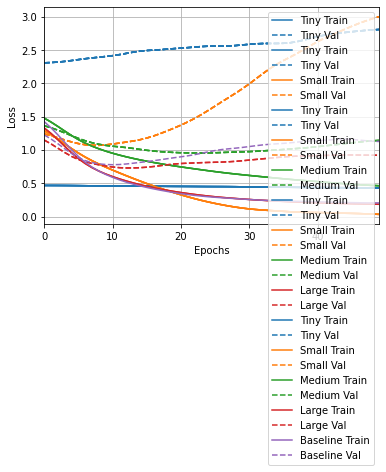

In [ ]:
# Train with early stopping callback
size_histories = {}
models = [tiny_model, small_model, medium_model, large_model, b_model]
sizes = ['tiny', 'small', 'medium', 'large', 'baseline']
for count, size in enumerate(sizes):
  tf.keras.backend.clear_session()
  size_histories[size] = compile_and_fit(models[count], optimizer=None, max_epochs=50)

  # Plot metric
  plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
  plotter.plot(size_histories)
  
  # Best validation accuracies
  val_acc_per_epoch = size_histories[size].history['val_accuracy']
  highest_val_accuracy = max(val_acc_per_epoch)
  best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
  print('Highest validation accuracy:', highest_val_accuracy )
  print('Best epoch: %d' % (best_epoch,))
  

In [ ]:
size_histories['tiny'].history

Summary of the various network results.


1.   It can be observed from the smaller networks in terms of the depth of the conv layers that while they show great signs of overfitting, using just a single conv layer and increasing the dense layer does not fix the validation accuracy much. With dropout, better results were observed but for this kind of data (CIFAR-10), a single CNN isn't expressive enough to learn the more complex features.
2.    Deeper CNN networks doesn't just increase hypothesis space and overfitting rate. It however encourages better learning - the CNN layers act as feature extraction layers and a validation accuracy of over 79% can be gotten from the baseline model without much tuning.
So we can continue tuning the baseline model for better results. 




# Hyperparameter tuning and Exploring Relationship between different hyperparameters.


1.   Tune Learning rate - In this section we intorduce the keras tuner to tune the learning rate.
2.   Tune batch size
1.   Effect of a good weight initializer.
2.   Effect of weight regularization and dropout layers.
1.   Effect of data argumentation.
2.   Effect of batch normalization.








USING KERAS TUNER.

1.   Define the hyper model. This can be done in two ways:


    *   By using a model builder function and by subclassing the HyperModel class (hp) of the Keras Tuner API. This model builder method is used in this notebook. The model builder function returns a compiled model and uses hyperparameters you define inline to tune the model.

    *   You can also use two pre-defined HyperModel classes - HyperXception and HyperResNet for computer vision applications.


2.   Instantiate the tuner (tuning algorithm) you desire amongst the tuners in the keras library and perform hypertuning by using the search method.
 

      *   To instantiate the Hyperband tuner, you must specify the hypermodel, the objective to optimize and the maximum number of epochs to train (max_epochs).
      *    The required search method arguments are same as those used in tf.keras.model.fit().





In [ ]:
# Tune Learning rate
# Baseline Model
def model_builder(hp):
  model = tf.keras.models.Sequential([
      tf.keras.layers.Rescaling(1./255),
      # Note the input shape is the desired size of the image 32x32 with 3 bytes color
      # This is the first convolution
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,3)), # output  channel size = 64, kernel size = 3,3
      # The second convolution
      tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D(2,2),

      # The third convolution
      tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
      # The fourth convolution
      tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D(2,2),

      # The fifth convolution
      tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
      # The sixth convolution
      tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D(2,2),

      # Flatten the results to feed into a DNN
      tf.keras.layers.Flatten(),
      # 1024 neuron hidden layer
      tf.keras.layers.Dense(1024, activation='relu'),
      # tf.keras.layers.Dropout(0.4),
      # 512 neuron hidden layer
      tf.keras.layers.Dense(512, activation='relu'),
      # tf.keras.layers.Dropout(0.4),
      # Output layer
      tf.keras.layers.Dense(num_classes)
  ])
  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 3e-2, 1e-3, 3e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

In [ ]:
# tf.keras.backend.clear_session()
def tuner_search():
  tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=50,
                     factor=3)
  stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
  tuner.search_space_summary()
  tuner.search(train_ds, epochs=30, validation_data=val_ds, callbacks=[stop_early])

  return tuner

In [ ]:
tuner = tuner_search()

Trial 90 Complete [00h 03m 31s]
val_accuracy: 0.10700000077486038

Best val_accuracy So Far: 0.7857999801635742
Total elapsed time: 01h 58m 15s


In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps['learning_rate']

0.001

In [ ]:
# Shows the 10 best trials
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
learning_rate: 0.001
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0047
Score: 0.7857999801635742
Trial summary
Hyperparameters:
learning_rate: 0.001
tuner/epochs: 17
tuner/initial_epoch: 6
tuner/bracket: 3
tuner/round: 2
tuner/trial_id: 0035
Score: 0.7851999998092651
Trial summary
Hyperparameters:
learning_rate: 0.001
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0067
Score: 0.7803999781608582
Trial summary
Hyperparameters:
learning_rate: 0.001
tuner/epochs: 17
tuner/initial_epoch: 6
tuner/bracket: 3
tuner/round: 2
tuner/trial_id: 0037
Score: 0.7789999842643738
Trial summary
Hyperparameters:
learning_rate: 0.001
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0046
Score: 0.777400016784668
Trial summary
Hyperparameters:
learning_rate: 0.001
tuner/epochs: 17
tuner

Epoch 1/100
400/400 [==============================] - 12s 22ms/step - loss: 1.7543 - accuracy: 0.3383 - val_loss: 1.3937 - val_accuracy: 0.4956
Epoch 2/100
400/400 [==============================] - 10s 24ms/step - loss: 1.1293 - accuracy: 0.5951 - val_loss: 1.0896 - val_accuracy: 0.6146
Epoch 3/100
400/400 [==============================] - 8s 20ms/step - loss: 0.8776 - accuracy: 0.6895 - val_loss: 0.8214 - val_accuracy: 0.7060
Epoch 4/100
400/400 [==============================] - 9s 22ms/step - loss: 0.7175 - accuracy: 0.7478 - val_loss: 0.7434 - val_accuracy: 0.7428
Epoch 5/100
400/400 [==============================] - 9s 22ms/step - loss: 0.5969 - accuracy: 0.7908 - val_loss: 0.7043 - val_accuracy: 0.7592
Epoch 6/100
400/400 [==============================] - 8s 20ms/step - loss: 0.4758 - accuracy: 0.8331 - val_loss: 0.7461 - val_accuracy: 0.7620
Epoch 7/100
400/400 [==============================] - 8s 20ms/step - loss: 0.3853 - accuracy: 0.8645 - val_loss: 0.8263 - val_accurac

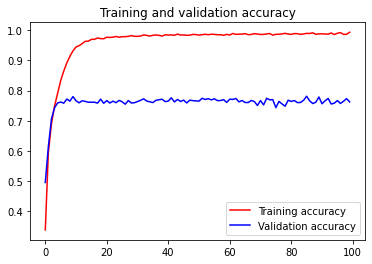

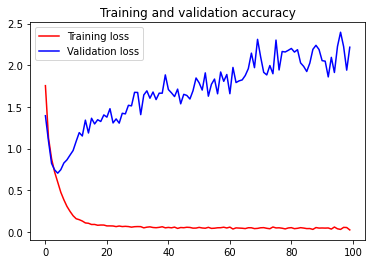

<Figure size 432x288 with 0 Axes>

Highest validation accuracy: 0.7814000248908997
Best epoch: 86


In [ ]:
# This method can be used to reinstantiate the (untrained) best model found during the search process.
best_hp = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hp)
# Retrain the model
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
history =  model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=[stop_early])
plot_loss_accuracy(filename=' for base-model + best_lr')
val_acc_per_epoch = history.history['val_accuracy']
highest_val_accuracy = max(val_acc_per_epoch)
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Highest validation accuracy:', highest_val_accuracy )
print('Best epoch: %d' % (best_epoch,))

In [ ]:
# See model summary just to confirm that the hypermodel build method works well
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 128)       147584    
                                                      

Observation about Keras tuner: While keras tuner is undeniably a good tool for tuning hyperparameters or for quickly accessing how well a model can behave with a quick glance. It can take a lot of training time, so I would not advise you to use it to tune a very large hyperparameter space, start from a pretty good point and work your way up.

*   The default learning rate, 0.001 was chosen by the hyperband tuner as the best learning rate so we stick with it.
*   Baseline model + best learning rate (0.001) = validation accuracy of 78.14%.





# Batch size tuning.

Tune Batch Size - Fortunately, the batch size hyperparameter though very important isn't dependent on any other hyperparameter so it can be tuned seperately once a good learning rate choice has been made. Also, the metric to be focused on is the speed, the batch size that gives the best result in the lowest time should be used. (A range of 32 batches is advised).

In [ ]:
# Baseline Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    # Note the input shape is the desired size of the image 32x32 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,3)), # output  channel size = 64, kernel size = 3,3
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    # tf.keras.layers.MaxPooling2D(),

    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    # tf.keras.layers.MaxPooling2D(),

    # The fifth convolution
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    # The sixth convolution
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    # tf.keras.layers.MaxPooling2D(),

    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 1024 neuron hidden layer
    # tf.keras.layers.Dense(1024, activation='relu'),
    # tf.keras.layers.Dropout(0.4),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # tf.keras.layers.Dropout(0.4),
    # Output layer
    tf.keras.layers.Dense(num_classes)
])

In [ ]:
# Let's choose best batch_size
# Choose baseline model - Loop through diff batch sizes with a factor 32 and choose the one with lowest time duration
from datetime import datetime
T = 5 # Run each model 10 times
inc = 32

time_list=[]
for bt_size in range(64,1600,64):
  import tensorflow_datasets as tfds
  (train_ds, val_ds, test_ds), metadata = tfds.load(
    'cifar10',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
      )
  
  batch_size=bt_size    # set batch_size
  train_ds = configure_for_performance(train_ds)
  val_ds = configure_for_performance(val_ds)


  t0 = datetime.now()
  history = compile_and_fit(model, optimizer=None, scheduler=None, max_epochs=2)
  tf.keras.backend.clear_session()  # Clear each model to avoid build up
  dt1 = (datetime.now() - t0)

  # For bt_size: here is the average time spent
  time_list.append([bt_size,dt1])


In [ ]:
time_list

[[64, datetime.timedelta(seconds=30, microseconds=85616)],
 [128, datetime.timedelta(seconds=23, microseconds=984690)],
 [192, datetime.timedelta(seconds=22, microseconds=809608)],
 [256, datetime.timedelta(seconds=25, microseconds=615636)],
 [320, datetime.timedelta(seconds=26, microseconds=183955)],
 [384, datetime.timedelta(seconds=24, microseconds=768331)],
 [448, datetime.timedelta(seconds=24, microseconds=710944)],
 [512, datetime.timedelta(seconds=27, microseconds=990583)],
 [576, datetime.timedelta(seconds=28, microseconds=187656)],
 [640, datetime.timedelta(seconds=28, microseconds=283662)],
 [704, datetime.timedelta(seconds=29, microseconds=815726)],
 [768, datetime.timedelta(seconds=28, microseconds=629703)],
 [832, datetime.timedelta(seconds=28, microseconds=702346)],
 [896, datetime.timedelta(seconds=29, microseconds=425363)],
 [960, datetime.timedelta(seconds=29, microseconds=580021)],
 [1024, datetime.timedelta(seconds=30, microseconds=81693)],
 [1088, datetime.timedelta

In [ ]:
time_list[1][1].total_seconds()

23.26512

In [ ]:
# There are more efficient ways to do this: Like using a dictionary but I will stick with the list method for now
# time_list[]
batch_list = [bt_size for bt_size in range(64,1600,64)]
tim_sec_list = [sec[1].total_seconds() for sec in time_list]
best_batch_size = batch_list[np.argmin(tim_sec_list)]

In [ ]:
best_batch_size

192

Best batch size = 192

After choosing the best batch size, re-configure your dataset.

In [ ]:
import tensorflow_datasets as tfds
(train_ds, val_ds, test_ds), metadata = tfds.load(
  'cifar10',
  split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
  with_info=True,
  as_supervised=True,
    )

batch_size=best_batch_size   # set batch_size
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

# Effect of Weight Initializer.



1. Examine the stand-alone effect of weight initialization on validation accuracy: Let's train the base model with the best/tuned learning rate and examine the effect of weight /and kernel initializer hyperparameter. 
2.  According to Yoshua Bengio's paper,'Practical Recommendations for Gradeint-based Training of Deep Archi, Sept,20212' , it is preferable to use the HE initializer with the RELU activation layer.






Baseline model + learning rate (0.001) = Validation accuracy is 78%

In [ ]:
tf.keras.backend.clear_session()
# Baseline Model 
model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    # Note the input shape is the desired size of the image 32x32 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,3), ), # output  channel size = 64, kernel size = 3,3
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),

    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),

     # The fifth convolution
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    # The sixth convolution
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),

    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 1024 neuron hidden layer
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    # Output layer
    tf.keras.layers.Dense(num_classes)
])

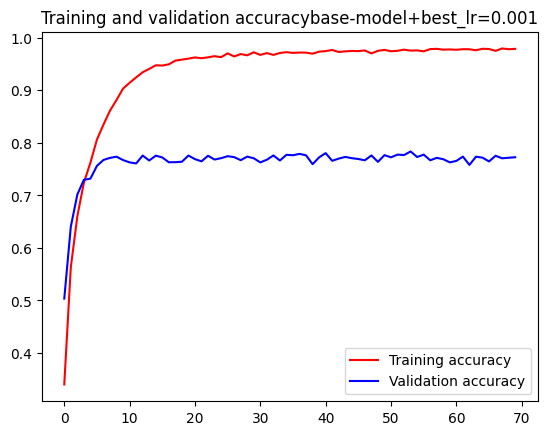

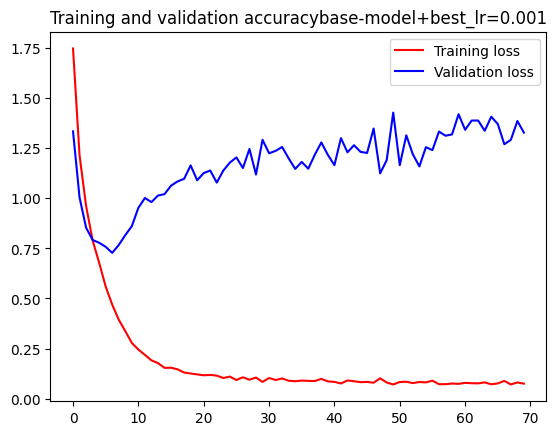

<Figure size 640x480 with 0 Axes>

Highest validation accuracy: 0.7835999727249146
Best epoch: 54


In [ ]:
# Compile, fit and plot
history = compile_and_fit(model, optimizer=None, max_epochs=70)
plot_loss_accuracy(filename='base-model+best_lr=0.001')
val_acc_per_epoch = history.history['val_accuracy']
highest_val_accuracy = max(val_acc_per_epoch)
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Highest validation accuracy:', highest_val_accuracy )
print('Best epoch: %d' % (best_epoch,))

Baseline model + learning rate (0.001) + HE_uniform weight intializer.

In [ ]:
tf.keras.backend.clear_session()
# Baseline Model + lr =0.001 + kernel/weight_initializer = 'he_uniform'
model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    # Note the input shape is the desired size of the image 32x32 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,3), kernel_initializer='he_uniform'), # output  channel size = 64, kernel size = 3,3
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform'),
    tf.keras.layers.MaxPooling2D(2,2),

    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform'),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform'),
    tf.keras.layers.MaxPooling2D(2,2),

     # The fifth convolution
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform'),
    # The sixth convolution
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform'),
    tf.keras.layers.MaxPooling2D(2,2),

    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 1024 neuron hidden layer
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    # Output layer
    tf.keras.layers.Dense(num_classes)
])

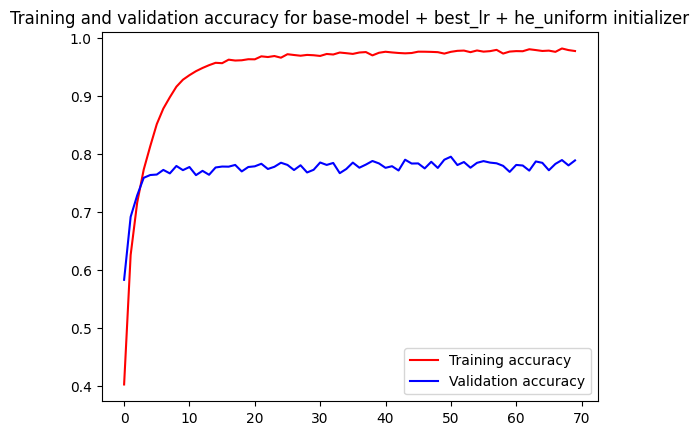

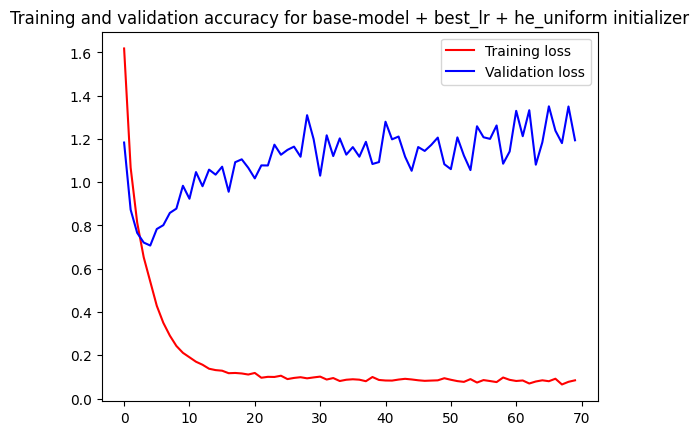

<Figure size 640x480 with 0 Axes>

Highest validation accuracy: 0.7954000234603882
Best epoch: 51


In [ ]:
# Compile, fit and plot
history = compile_and_fit(model, optimizer=None, max_epochs=70)
plot_loss_accuracy(filename=' for base-model + best_lr + he_uniform initializer')
val_acc_per_epoch = history.history['val_accuracy']
highest_val_accuracy = max(val_acc_per_epoch)
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Highest validation accuracy:', highest_val_accuracy )
print('Best epoch: %d' % (best_epoch,))

Results: 


*   Baseline model + lr = 0.001; got 78% validation accuracy.
*   Baseline model + learning rate (0.001) + HE_uniform weight intializer; got 79.54% validation accuracy.


The validation accuracy improved by over 1.5% compared to the baseline + lr =0.001 model. 

# Effect of Weight/Kernel Regularizers and Tuning of the regularization parameters.
1.   Tune weight regularization parameters for each layer.
2.   Examine the stand-alone effect of weight regularization and its combined effect with dropout.

Weight Regularizer Tuner - Different regularizers for every layer. In this section, we tune the kernel regularization parameters for each CNN layer and use the best regularization parameters to examine the effect of weight regularizers on the model.


Note: It can be observed in some cases in this notebook that the tuner.hypermodel.build() method of building the hypermodel (model containing tuned parameters from the keras tuner) is not used to automatically build the model after tuning, rather the model is built manually using the best hyperparameters, this is because these codes were executed at different times, so the best hyperparameters from the tuner were saved (to avoid having to retune again) and used to build other models.




In [ ]:
def model_builder(hp):
  # hp_reg_rate = hp.Choice('reg_rate', values=[0.00 , 1e-2 , 3e-3 , 1e-3])
  # hp_reg_rate = 0

  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Rescaling(1./255))
  # Note the input shape is the desired size of the image 32x32 with 3 bytes color
  # This is the first convolution
  model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,3),
                                   kernel_regularizer=regularizers.L2(hp.Choice('reg_rate1', values=[0.00 , 1e-2 , 3e-3 , 1e-3])))) # output  channel size = 64, kernel size = 3,3
  # The second convolution
  model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same',
                                   kernel_regularizer=regularizers.L2(hp.Choice('reg_rate2', values=[0.00 , 1e-2 , 3e-3 , 1e-3]))))
  model.add(tf.keras.layers.MaxPooling2D(2,2))

  # The third convolution
  model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same',
                                   kernel_regularizer=regularizers.L2(hp.Choice('reg_rate3', values=[0.00 , 1e-2 , 3e-3 , 1e-3]))))
  # The fourth convolution
  model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same',
                                   kernel_regularizer=regularizers.L2(hp.Choice('reg_rate4', values=[0.00 , 1e-2 , 3e-3 , 1e-3]))))
  model.add(tf.keras.layers.MaxPooling2D(2,2))

  # The fifth convolution
  model.add(tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same',
                                   kernel_regularizer=regularizers.L2(hp.Choice('reg_rate5', values=[0.00 , 1e-2 , 3e-3 , 1e-3]))))
  # The sixth convolution
  model.add(tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same',
                                   kernel_regularizer=regularizers.L2(hp.Choice('reg_rate6', values=[0.00 , 1e-2 , 3e-3 , 1e-3]))))
  model.add(tf.keras.layers.MaxPooling2D(2,2))

  # Flatten the results to feed into a DNN
  model.add(tf.keras.layers.Flatten())
  # 1024 neuron hidden layer
  model.add(tf.keras.layers.Dense(1024, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.4))
  # 512 neuron hidden layer
  model.add(tf.keras.layers.Dense(512, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.4))
  # Output layer
  model.add(tf.keras.layers.Dense(num_classes))

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=30,
                     factor=3,
                    directory='LOG_DIR',
                     project_name='kt_for_cifar10')
# Create a callback to stop training early after reaching a certain value for the validation loss.
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
reg_rate1 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.01, 0.003, 0.001], 'ordered': True}
reg_rate2 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.01, 0.003, 0.001], 'ordered': True}
reg_rate3 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.01, 0.003, 0.001], 'ordered': True}
reg_rate4 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.01, 0.003, 0.001], 'ordered': True}
reg_rate5 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.01, 0.003, 0.001], 'ordered': True}
reg_rate6 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.01, 0.003, 0.001], 'ordered': True}


In [ ]:
tuner.search(train_ds, epochs=50, validation_data=val_ds, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
best_hps.get('reg_rate6')


0.003

In [ ]:
# Shows the 10 best trials
tuner.results_summary()

In [ ]:
tuner.get_best_hyperparameters()[0].values

{'reg_rate1': 0.0,
 'reg_rate2': 0.0,
 'reg_rate3': 0.001,
 'reg_rate4': 0.001,
 'reg_rate5': 0.003,
 'reg_rate6': 0.003,
 'tuner/epochs': 30,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

Now let's improve learning - Add weight regularizer (we have tuned this before) so let's train and observe improvement. Initially, we will use weight regularizers only, then we will add dropout on every conv layer to see effect.

In [ ]:
tf.keras.backend.clear_session()
# Baseline Model + lr =0.001 + kernel/weight_initializer = 'he_uniform' +tuned weight_regularizers
model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    # Note the input shape is the desired size of the image 32x32 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,3), kernel_initializer='he_uniform', kernel_regularizer=regularizers.L2(0.00)), # output  channel size = 64, kernel size = 3,3
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', kernel_regularizer=regularizers.L2(0.00)),
    tf.keras.layers.MaxPooling2D(2,2),

    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', kernel_regularizer=regularizers.L2(0.001)),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', kernel_regularizer=regularizers.L2(0.001)),
    tf.keras.layers.MaxPooling2D(2,2),

     # The fifth convolution
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', kernel_regularizer=regularizers.L2(0.003)),
    # The sixth convolution
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', kernel_regularizer=regularizers.L2(0.003)),
    tf.keras.layers.MaxPooling2D(2,2),

    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 1024 neuron hidden layer
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    # Output layer
    tf.keras.layers.Dense(num_classes)
])

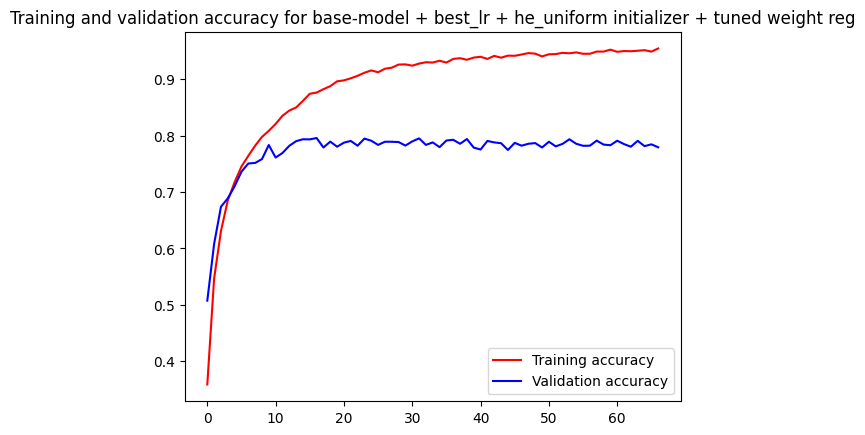

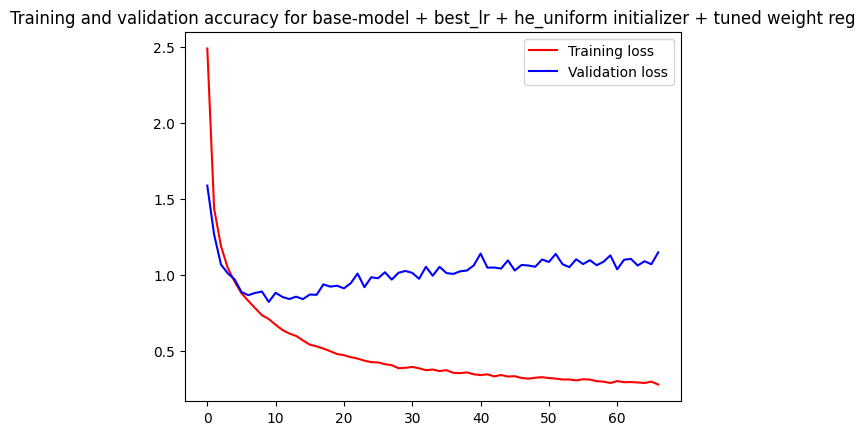

<Figure size 640x480 with 0 Axes>

Highest validation accuracy: 0.795799970626831
Best epoch: 17


In [ ]:
# Compile, fit and plot
history = compile_and_fit(model, optimizer=None, max_epochs=70)
plot_loss_accuracy(filename=' for base-model + best_lr + he_uniform initializer + tuned weight reg')
val_acc_per_epoch = history.history['val_accuracy']
highest_val_accuracy = max(val_acc_per_epoch)
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Highest validation accuracy:', highest_val_accuracy )
print('Best epoch: %d' % (best_epoch,))

The validation accuracy did not improve much from when regularization parmeters were absent, 79.54 - 79.58%, less that 0.05 increase was seen. This is because, weight regularizers improve network learning ability by constraining or reducing the parameter space, so the best model within the constrained space is chosen.


*   Baseline model + lr(0.001) + he_uniform initializer + tuned weight regularization parameters, validation accuracy = 79.58%.




# Stand-alone effect of dropout and combined effect of dropout and weight regularization.

Base Model + Best_lr(0.001) + He_uniform intializer + Dropout.

In [ ]:
tf.keras.backend.clear_session()
# Baseline Model + lr =0.001 + kernel/weight_initializer = 'he_uniform' +tuned weight_regularizers + Dropout
model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    # Note the input shape is the desired size of the image 32x32 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,3), kernel_initializer='he_uniform', 
                           kernel_regularizer=regularizers.L2(0.00)), # output  channel size = 64, kernel size = 3,3
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', kernel_regularizer=regularizers.L2(0.00)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),

    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', kernel_regularizer=regularizers.L2(0.00)),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', kernel_regularizer=regularizers.L2(0.00)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),

     # The fifth convolution
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', kernel_regularizer=regularizers.L2(0.00)),
    # The sixth convolution
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', kernel_regularizer=regularizers.L2(0.00)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),

    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 1024 neuron hidden layer
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    # Output layer
    tf.keras.layers.Dense(num_classes)
])

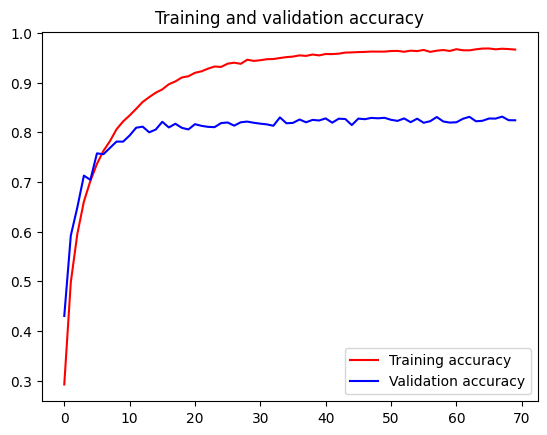

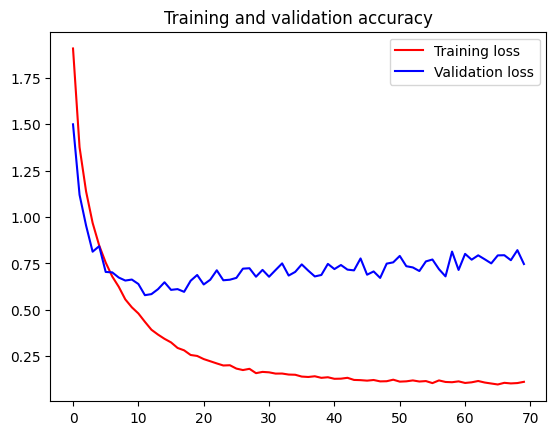

<Figure size 640x480 with 0 Axes>

Highest validation accuracy: 0.8313999772071838
Best epoch: 68


In [ ]:
# Compile, fit and plot
history = compile_and_fit(model, optimizer=None, max_epochs=70)
plot_loss_accuracy(filename=' for base-model + best_lr + he_uniform initializer + dropout')
val_acc_per_epoch = history.history['val_accuracy']
highest_val_accuracy = max(val_acc_per_epoch)
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Highest validation accuracy:', highest_val_accuracy )
print('Best epoch: %d' % (best_epoch,))

Base Model + Best_lr(0.001) + He_uniform intializer + Dropout; validation accuracy = 83.14%. 

Combined effect of weight regularizers and dropout layers.

In [ ]:
tf.keras.backend.clear_session()
# Baseline Model + lr =0.001 + kernel/weight_initializer = 'he_uniform' +tuned weight_regularizers + Dropout
model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    # Note the input shape is the desired size of the image 32x32 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,3), kernel_initializer='he_uniform', kernel_regularizer=regularizers.L2(0.00)), # output  channel size = 64, kernel size = 3,3
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', kernel_regularizer=regularizers.L2(0.00)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),

    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', kernel_regularizer=regularizers.L2(0.001)),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', kernel_regularizer=regularizers.L2(0.001)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),

     # The fifth convolution
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', kernel_regularizer=regularizers.L2(0.003)),
    # The sixth convolution
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', kernel_regularizer=regularizers.L2(0.003)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),

    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 1024 neuron hidden layer
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    # Output layer
    tf.keras.layers.Dense(num_classes)
])

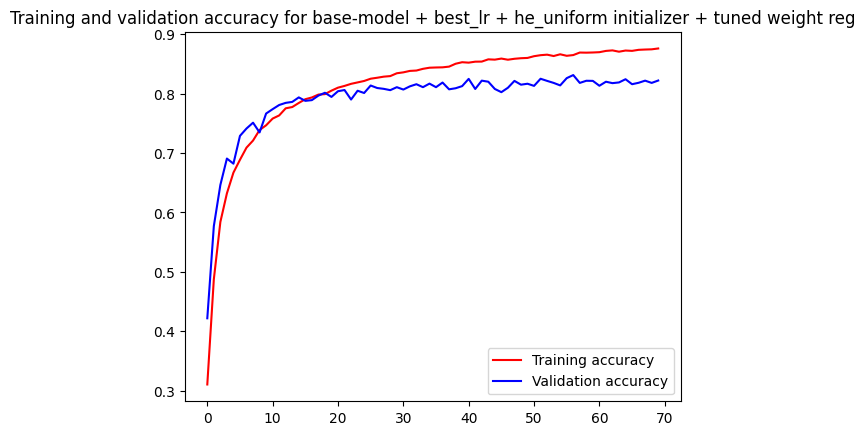

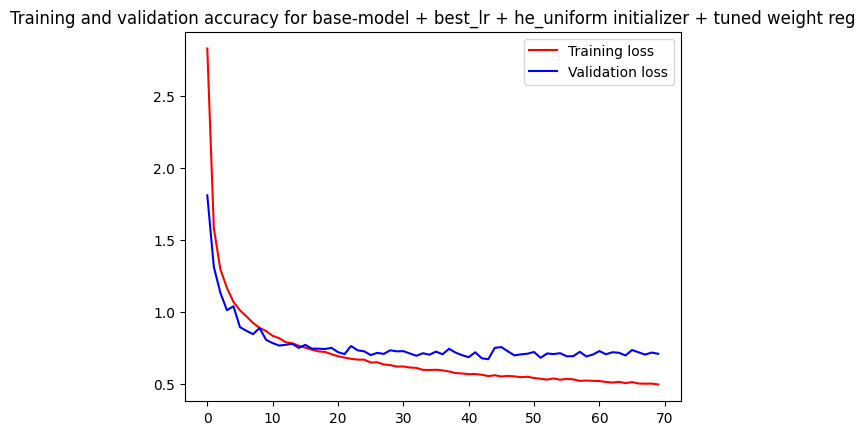

<Figure size 640x480 with 0 Axes>

Highest validation accuracy: 0.8312000036239624
Best epoch: 57


In [ ]:
# Compile, fit and plot
history = compile_and_fit(model, optimizer=None, max_epochs=70)
plot_loss_accuracy(filename=' for base-model + best_lr + he_uniform initializer + tuned weight reg')
val_acc_per_epoch = history.history['val_accuracy']
highest_val_accuracy = max(val_acc_per_epoch)
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Highest validation accuracy:', highest_val_accuracy )
print('Best epoch: %d' % (best_epoch,))

Base Model + Best_lr(0.001) + He_uniform intializer + Dropout + tuned weight regularizers = 83.1%. The stand alone effect of dropout and combined effect with tuned weights have almost the same effect, a better result might be achieved if the weight regularization paramters and dropout rates are tuned together. 

This is a very impressive improvement over the previous ones - Dropout helps to achieve better generalization by randomly knocking out some units during traing so that we are working with a smaller network but most importantly, it helps to spread out the weights, it limits the dependencis between the neurons in the layer. This attribute of randomly eliminating some activation units forces the network to learn better. Without data argumentation and a good amount of dropout, we were able to get a validation accuracy of 83%, so with data argumentation and well tuned dropout parameters, we should get a higher validation accuracy.

# Effect of data argumentation.

1.   Standalone effect on baseline model.
2.   Combined effect of data argumentation, dropout and weight regularizers.



Let's see the effect of data argumentation on base model then we check the effect with other hyperparameters.

*  The image argumentation layers are part of the keras image preprocessing layers, so they can be easily added to the model.
*   These argumentations were used: layers.RandomFlip("horizontal_and_vertical"), layers.RandomRotation(0.2)



In [ ]:
# Baseline Model + lr =0.001 + kernel/weight_initializer = 'he_uniform'
model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    # Note the input shape is the desired size of the image 32x32 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,3), kernel_initializer='he_uniform'), # output  channel size = 64, kernel size = 3,3
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform'),
    tf.keras.layers.MaxPooling2D(2,2),

    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform'),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform'),
    tf.keras.layers.MaxPooling2D(2,2),

     # The fifth convolution
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform'),
    # The sixth convolution
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform'),
    tf.keras.layers.MaxPooling2D(2,2),

    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 1024 neuron hidden layer
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    # Output layer
    tf.keras.layers.Dense(num_classes)
])

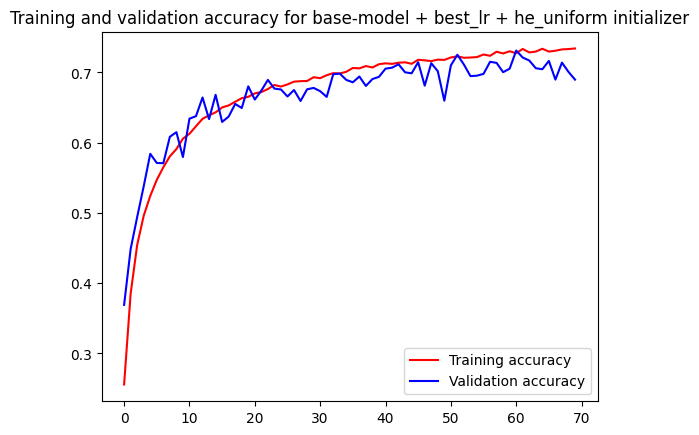

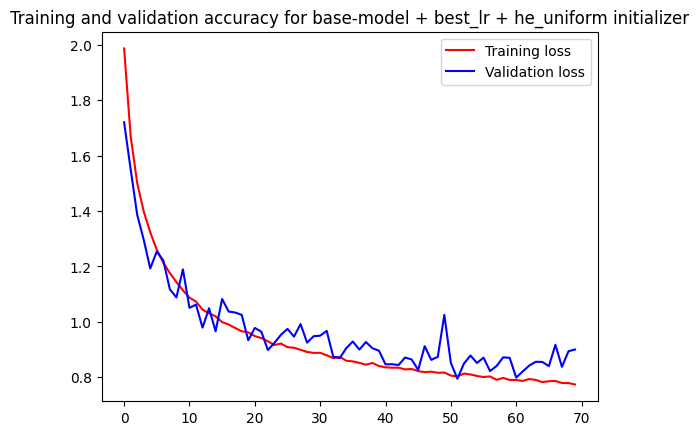

<Figure size 640x480 with 0 Axes>

Highest validation accuracy: 0.7311999797821045
Best epoch: 61


In [ ]:
tf.keras.backend.clear_session()
# Compile, fit and plot
history = compile_and_fit(model, optimizer=None, max_epochs=70)
plot_loss_accuracy(filename=' for base-model + best_lr + he_uniform initializer')
val_acc_per_epoch = history.history['val_accuracy']
highest_val_accuracy = max(val_acc_per_epoch)
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Highest validation accuracy:', highest_val_accuracy )
print('Best epoch: %d' % (best_epoch,))

The effect of data argumentation on overfitting is just amazing. Just like dropout but with another approach, it forces the network to learn complex interations and features, thereby greatly reducing overfitting. It also requires longer training.

*   Baseline model + best lr (0.001) + he_uniform initializer + data argumentation; 73.1% validation accuracy with less generalization error between in-sample (training) and out-of-sample (validation) error.



Let's tune hyperparameters using keras tuner, best_batch_size, HE regularizer, Data argumentation, 

In [ ]:
# HYPERMODEL
# regularizers tuner (dropuot and weight_initializer)
def build_model(hp):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Rescaling(1./255))
  model.add(tf.keras.layers.RandomFlip("horizontal_and_vertical"))
  model.add(tf.keras.layers.RandomRotation(0.2))
  # Note the input shape is the desired size of the image 32x32 with 3 bytes color
  # This is the first convolution
  model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,3), kernel_initializer='he_uniform', 
                                   kernel_regularizer=regularizers.L2(hp.Choice('reg_rate1', values=[0.00 , 1e-2 , 3e-3 , 1e-3])))) # output  channel size = 64, kernel size = 3,3
  model.add(layers.BatchNormalization())
  # The second convolution
  model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', 
                                   kernel_regularizer=regularizers.L2(hp.Choice('reg_rate2', values=[0.00 , 1e-2 , 3e-3 , 1e-3]))))
  model.add(layers.BatchNormalization())
  model.add(tf.keras.layers.MaxPooling2D(2,2))
  model.add(tf.keras.layers.Dropout(hp.Choice('drop_rate1', values=[0.00 , 0.2 , 0.4 , 0.6])))

  # The third convolution
  model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', 
                                   kernel_regularizer=regularizers.L2(hp.Choice('reg_rate3', values=[0.00 , 1e-2 , 3e-3 , 1e-3]))))
  model.add(layers.BatchNormalization())
  # The fourth convolution
  model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', 
                                   kernel_regularizer=regularizers.L2(hp.Choice('reg_rate4', values=[0.00 , 1e-2 , 3e-3 , 1e-3]))))
  model.add(layers.BatchNormalization())
  model.add(tf.keras.layers.MaxPooling2D(2,2))
  model.add(tf.keras.layers.Dropout(hp.Choice('drop_rate2', values=[0.00 , 0.2 , 0.4 , 0.6])))

  # The fifth convolution
  model.add(tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', 
                                   kernel_regularizer=regularizers.L2(hp.Choice('reg_rate5', values=[0.00 , 1e-2 , 3e-3 , 1e-3]))))
  model.add(layers.BatchNormalization())
  # The sixth convolution
  model.add(tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', 
                                   kernel_regularizer=regularizers.L2(hp.Choice('reg_rate6', values=[0.00 , 1e-2 , 3e-3 , 1e-3]))))
  model.add(layers.BatchNormalization())
  model.add(tf.keras.layers.MaxPooling2D(2,2))
  model.add(tf.keras.layers.Dropout(hp.Choice('drop_rate3', values=[0.00 , 0.2 , 0.4 , 0.6])))

  # Flatten the results to feed into a DNN
  model.add(tf.keras.layers.Flatten())
  # 1024 neuron hidden layer
  model.add(tf.keras.layers.Dense(1024, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(hp.Choice('drop_rate4', values=[0.00 , 0.2 , 0.4 , 0.6, 0.8])))
  # 512 neuron hidden layer
  model.add(tf.keras.layers.Dense(512, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(hp.Choice('drop_rate5', values=[0.00 , 0.2 , 0.4 , 0.6, 0.8])))
  # Output layer
  model.add(tf.keras.layers.Dense(num_classes))

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [ ]:
tuner = kt.Hyperband(build_model,
                    objective='val_accuracy',
                    max_epochs=40,
                    factor=3,
                    directory='kt_tunning',
                    project_name='CFAR_BNORM'
                    )
tuner.search_space_summary()

Search space summary
Default search space size: 11
reg_rate1 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.01, 0.003, 0.001], 'ordered': True}
reg_rate2 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.01, 0.003, 0.001], 'ordered': True}
drop_rate1 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.2, 0.4, 0.6], 'ordered': True}
reg_rate3 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.01, 0.003, 0.001], 'ordered': True}
reg_rate4 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.01, 0.003, 0.001], 'ordered': True}
drop_rate2 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.2, 0.4, 0.6], 'ordered': True}
reg_rate5 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.01, 0.003, 0.001], 'ordered': True}
reg_rate6 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.01, 0.003, 0.001], 'ordered': True}
drop_rate3 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.2, 0.4, 0.6], 'order

In [ ]:
# Now search
tuner.search(train_ds, epochs=50, validation_data=val_ds)

Trial 90 Complete [00h 02m 51s]
val_accuracy: 0.6474000215530396

Best val_accuracy So Far: 0.7670000195503235
Total elapsed time: 00h 55m 42s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
# get_best_hyperparameters method - Returns the best hyperparameters as determined by the objective
# num_trials: Optional number of HyperParameters objects to return - Returns a List of HyperParameter objects sorted from the best to the worst.
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

In [ ]:
best_hps['reg_rate2']

0.01

In [ ]:
# Shows the 10 best trials
tuner.results_summary()

Results summary
Results in kt_tunning\CFAR_BNORM
Showing 10 best trials
Trial summary
Hyperparameters:
reg_rate1: 0.001
reg_rate2: 0.01
drop_rate1: 0.2
reg_rate3: 0.001
reg_rate4: 0.001
drop_rate2: 0.0
reg_rate5: 0.001
reg_rate6: 0.0
drop_rate3: 0.0
drop_rate4: 0.0
drop_rate5: 0.2
tuner/epochs: 40
tuner/initial_epoch: 14
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0070
Score: 0.7670000195503235
Trial summary
Hyperparameters:
reg_rate1: 0.0
reg_rate2: 0.001
drop_rate1: 0.0
reg_rate3: 0.001
reg_rate4: 0.0
drop_rate2: 0.0
reg_rate5: 0.003
reg_rate6: 0.001
drop_rate3: 0.0
drop_rate4: 0.4
drop_rate5: 0.4
tuner/epochs: 40
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.7652000188827515
Trial summary
Hyperparameters:
reg_rate1: 0.003
reg_rate2: 0.001
drop_rate1: 0.0
reg_rate3: 0.01
reg_rate4: 0.003
drop_rate2: 0.0
reg_rate5: 0.0
reg_rate6: 0.01
drop_rate3: 0.0
drop_rate4: 0.0
drop_rate5: 0.0
tuner/epochs: 40
tuner/initial_epoch: 14
tuner/bracket: 3
tuner/round: 3
tuner/tri

In [ ]:
# This method can be used to reinstantiate the (untrained) best model found during the search process.
best_hp = tuner.get_best_hyperparameters()[0]

In [ ]:
# Get best model - This method is for querying the models trained during the search. 
# For best performance, it is recommended to retrain your Model on the full dataset using the best hyperparameters found during search, which can be obtained using tuner.get_best_hyperparameters().
best_model = tuner.get_best_models(num_models=1)

In [ ]:
best_model

In [ ]:
model = tuner.hypermodel.build(best_hp)

In [ ]:
# Retrain the model
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
history =  model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=[stop_early])

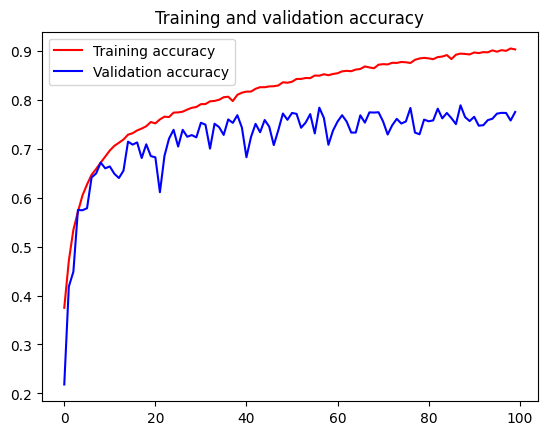

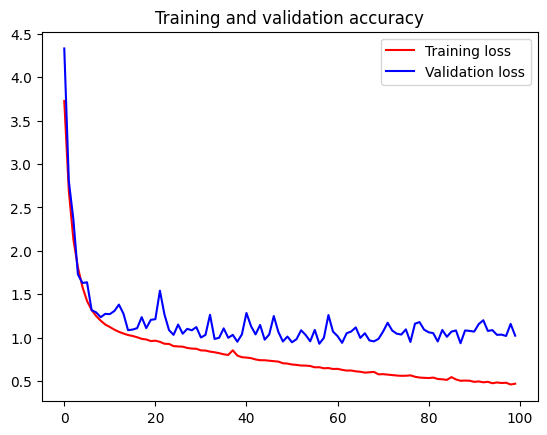

<Figure size 640x480 with 0 Axes>

Highest validation accuracy: 0.7882000207901001
Best epoch: 88


In [ ]:
# Compile, fit and plot
# history = compile_and_fit(model, optimizer=None, max_epochs=70)
plot_loss_accuracy(filename=' for base-model + best_lr + he_uniform initializer + dropout')
val_acc_per_epoch = history.history['val_accuracy']
highest_val_accuracy = max(val_acc_per_epoch)
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Highest validation accuracy:', highest_val_accuracy )
print('Best epoch: %d' % (best_epoch,))

In [ ]:
model.summary()

Baseline model + best lr + He-uniform init + tuned dropout + tuned weight regularizers + data argumentation; validation accuracy = 78.82%. This shows the same effect we observed with weight regularizer + dropout constraining the parameter space too much and limiting the learning or expressiveness of the model. To fix this, the weight regularizers where removed and dropout and data argumentation were used in the final model.

# Final Model.

1.   It can be observed that data argumentation and dropout layers force the network to learn more complex relationships between features. They have very great effects in reducing overfitting and encouraging better generalization. However, a combination of dropout and weight regularizers can restrain the model too much and impede the learning process as seen above, so for the final model, the weight regularizers are set to 0.
2.   An accuracy of 87% was achieved and this can be improved using RESNET network which will be implemented in the next module.



In [ ]:
# regularizers tuner (dropuot and weight_initializer) + Batch Norm..
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Rescaling(1./255))
model.add(tf.keras.layers.RandomFlip("horizontal_and_vertical"))
model.add(tf.keras.layers.RandomRotation(0.3))
# Note the input shape is the desired size of the image 32x32 with 3 bytes color
# This is the first convolution
model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,3), kernel_initializer='he_uniform', 
                                  kernel_regularizer=regularizers.L2(0.00))) # output  channel size = 64, kernel size = 3,3
model.add(layers.BatchNormalization())
# The second convolution
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', 
                                  kernel_regularizer=regularizers.L2(0.00)))
model.add(layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Dropout(0.0))


# The third convolution
model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', 
                                  kernel_regularizer=regularizers.L2(0.00)))
model.add(layers.BatchNormalization())
# The fourth convolution
model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', 
                                  kernel_regularizer=regularizers.L2(0.00)))
model.add(layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Dropout(0.4))

# The fifth convolution
model.add(tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', 
                                  kernel_regularizer=regularizers.L2(0.00)))
model.add(layers.BatchNormalization())
# The sixth convolution
model.add(tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', 
                                  kernel_regularizer=regularizers.L2(0.00)))
model.add(layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Dropout(0.6))

# Flatten the results to feed into a DNN
model.add(tf.keras.layers.Flatten())
# 1024 neuron hidden layer
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
# 512 neuron hidden layer
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.8))
# Output layer
model.add(tf.keras.layers.Dense(num_classes))


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
tf.keras.backend.clear_session()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_ds,epochs=200,validation_data=val_ds)

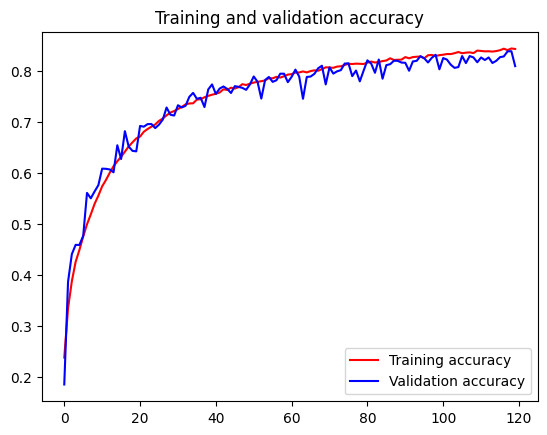

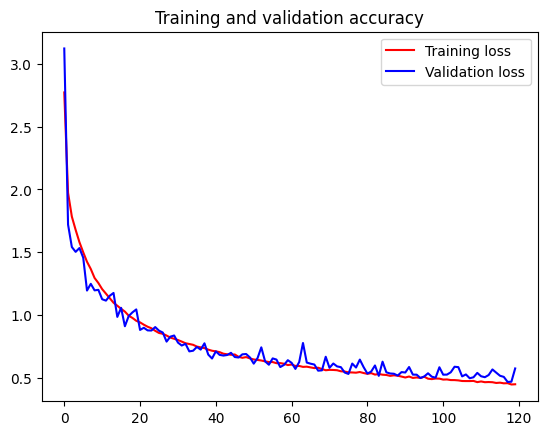

<Figure size 640x480 with 0 Axes>

Highest validation accuracy: 0.8388000130653381
Best epoch: 119


In [ ]:
plot_loss_accuracy(filename=' for base-model + best_lr + he_uniform initializer + dropout')
val_acc_per_epoch = history.history['val_accuracy']
highest_val_accuracy = max(val_acc_per_epoch)
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Highest validation accuracy:', highest_val_accuracy )
print('Best epoch: %d' % (best_epoch,))

By tuning the dropout rates a little and increasing training epochs, we were able to achive a validation accuaracy of 86%.

In [ ]:
# HYPERMODEL
# regularizers tuner (dropuot and weight_initializer)
def build_model(hp):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Rescaling(1./255))
  model.add(tf.keras.layers.RandomFlip("horizontal_and_vertical"))
  model.add(tf.keras.layers.RandomRotation(0.2))
  # Note the input shape is the desired size of the image 32x32 with 3 bytes color
  # This is the first convolution
  model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,3), kernel_initializer='he_uniform')) 
  model.add(layers.BatchNormalization())
  # The second convolution
  model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform'))
  model.add(layers.BatchNormalization())
  model.add(tf.keras.layers.MaxPooling2D(2,2))
  model.add(tf.keras.layers.Dropout(hp.Choice('drop_rate1', values=[0.00 , 0.2 , 0.4 , 0.6, 0.8])))

  # The third convolution
  model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform'))
  model.add(layers.BatchNormalization())
  # The fourth convolution
  model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform'))
  model.add(layers.BatchNormalization())
  model.add(tf.keras.layers.MaxPooling2D(2,2))
  model.add(tf.keras.layers.Dropout(hp.Choice('drop_rate2', values=[0.00 , 0.2 , 0.4 , 0.6, 0.8])))

  # The fifth convolution
  model.add(tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform'))
  model.add(layers.BatchNormalization())
  # The sixth convolution
  model.add(tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform')) 
  model.add(layers.BatchNormalization())
  model.add(tf.keras.layers.MaxPooling2D(2,2))
  model.add(tf.keras.layers.Dropout(hp.Choice('drop_rate3', values=[0.00 , 0.2 , 0.4 , 0.6, 0.8])))

  # Flatten the results to feed into a DNN
  model.add(tf.keras.layers.Flatten())
  # 1024 neuron hidden layer
  model.add(tf.keras.layers.Dense(1024, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(hp.Choice('drop_rate4', values=[0.00 , 0.2 , 0.4 , 0.6, 0.8])))
  # 512 neuron hidden layer
  model.add(tf.keras.layers.Dense(512, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(hp.Choice('drop_rate5', values=[0.00 , 0.2 , 0.4 , 0.6, 0.8])))
  # Output layer
  model.add(tf.keras.layers.Dense(num_classes))

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [ ]:
tuner = kt.Hyperband(build_model,
                    objective='val_accuracy',
                    max_epochs=40,
                    factor=3,
                    directory='dropout_tuning',
                    project_name='CFAR_dropout'
                    )
tuner.search_space_summary()

Search space summary
Default search space size: 5
drop_rate1 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.2, 0.4, 0.6, 0.8], 'ordered': True}
drop_rate2 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.2, 0.4, 0.6, 0.8], 'ordered': True}
drop_rate3 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.2, 0.4, 0.6, 0.8], 'ordered': True}
drop_rate4 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.2, 0.4, 0.6, 0.8], 'ordered': True}
drop_rate5 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.2, 0.4, 0.6, 0.8], 'ordered': True}


In [ ]:
# Now search
tuner.search(train_ds, epochs=50, validation_data=val_ds)

Trial 90 Complete [00h 02m 51s]
val_accuracy: 0.7034000158309937

Best val_accuracy So Far: 0.8055999875068665
Total elapsed time: 00h 54m 15s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
# get_best_hyperparameters method - Returns the best hyperparameters as determined by the objective
# num_trials: Optional number of HyperParameters objects to return - Returns a List of HyperParameter objects sorted from the best to the worst.
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

In [ ]:
best_hps['drop_rate2']

0.0

In [ ]:
# Shows the 10 best trials
tuner.results_summary()

In [ ]:
# This method can be used to reinstantiate the (untrained) best model found during the search process.
best_hp = tuner.get_best_hyperparameters()[0]

In [ ]:
model = tuner.hypermodel.build(best_hp)

In [ ]:
# Retrain the model
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
history =  model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=[stop_early])

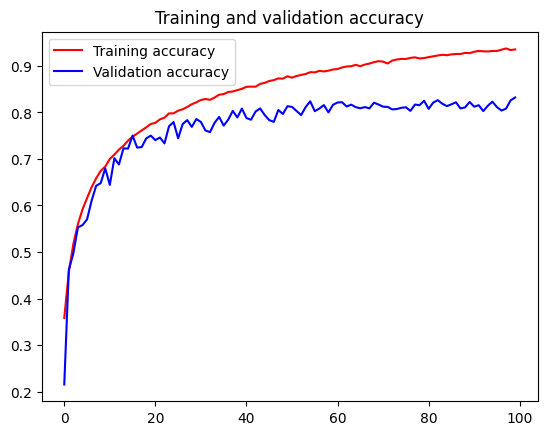

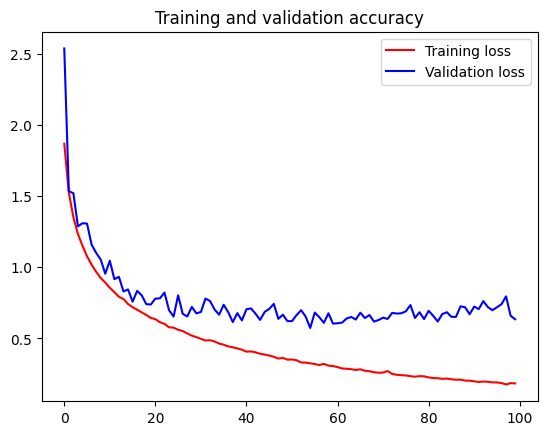

<Figure size 640x480 with 0 Axes>

Highest validation accuracy: 0.8320000171661377
Best epoch: 100


In [ ]:
# Compile, fit and plot
# history = compile_and_fit(model, optimizer=None, max_epochs=70)
plot_loss_accuracy(filename=' for base-model + best_lr + he_uniform initializer + dropout')
val_acc_per_epoch = history.history['val_accuracy']
highest_val_accuracy = max(val_acc_per_epoch)
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Highest validation accuracy:', highest_val_accuracy )
print('Best epoch: %d' % (best_epoch,))

In [ ]:
model.summary()

Observation: For keras tuner to work well set the early stopping callback way.......

Tune dropout.

In [ ]:
# regularizers tuner (dropuot and weight_initializer) + Batch Norm..
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Rescaling(1./255))
model.add(tf.keras.layers.RandomFlip("horizontal_and_vertical"))
model.add(tf.keras.layers.RandomRotation(0.2))
# Note the input shape is the desired size of the image 32x32 with 3 bytes color
# This is the first convolution
model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,3), kernel_initializer='he_uniform')) 
                                 
model.add(layers.BatchNormalization())
# The second convolution
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform')) 

model.add(layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Dropout(0.2))


# The third convolution
model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform')) 

model.add(layers.BatchNormalization())
# The fourth convolution
model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform'))

model.add(layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Dropout(0.4))

# The fifth convolution
model.add(tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform')) 

model.add(layers.BatchNormalization())
# The sixth convolution
model.add(tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform')) 

model.add(layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Dropout(0.6))

# Flatten the results to feed into a DNN
model.add(tf.keras.layers.Flatten())
# 1024 neuron hidden layer
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.6))
# 512 neuron hidden layer
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.8))
# Output layer
model.add(tf.keras.layers.Dense(num_classes))


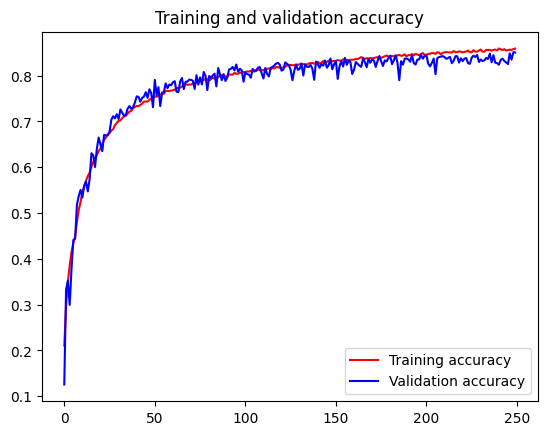

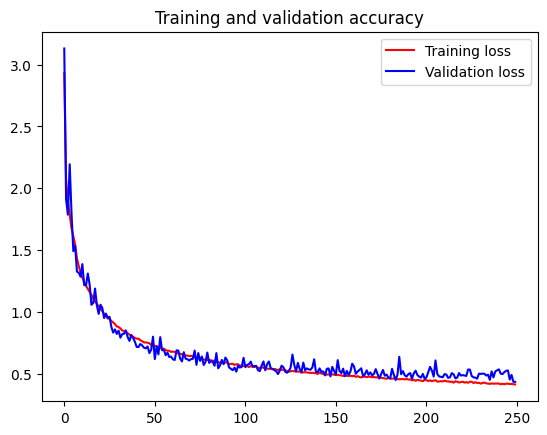

<Figure size 640x480 with 0 Axes>

Highest validation accuracy: 0.8514000177383423
Best epoch: 249


In [ ]:
history = history = compile_and_fit(model, optimizer=None, max_epochs=250)
plot_loss_accuracy(filename='Final_Model')
val_acc_per_epoch = history.history['val_accuracy']
highest_val_accuracy = max(val_acc_per_epoch)
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Highest validation accuracy:', highest_val_accuracy )
print('Best epoch: %d' % (best_epoch,))

# Other Hyperparameters like activation function, optimizer and loss function.

*   Activation function: The 'RELU' activation function was used throughout in this notebook because it has been proven to work better than the others like sigmoid and tanh functions. So while there my be a lack of full theory to proof why it works better, it has helped the training process significantly. And when in doubt, just use 'RELU' . Also using 'RELU' activation functions works well with cross entropy loss used in this exercise.               
*   Optimizer: The 'Adam' optimizer was used in this work. The ADAM optimizer has also been empirically proven to consistently outperform other optimizers like (SGD, SGD with momentum, RMSprop e.t.c.) on many models and datsets. It is also a versatile algorithm that scales to large-scale-high-dimensional problems like an image classification problem.

*   The SparseCategoricalCrossentropy loss function was used because it works well with the 'RELU' activation. The categorical crossentropy can be used as well and it is tested below.





Using the categorical crossentropy loss rather than the sparse categorical crossentropy loss.

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/cifar10.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)  # It downloads data from url if it is not already in cache
data_dir = pathlib.Path(archive).with_suffix('')

In [ ]:
data_dir

In [ ]:
import os
import PIL
import PIL.Image
import tensorflow_datasets as tfds

In [ ]:
# Now you have a copy of the images available in data_dir
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

In [ ]:
batch_size = 192
img_height = 32
img_width = 32

# Train dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  label_mode="categorical",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  label_mode="categorical",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Class Name Attribute of the dataset - You can find the class names in the class_names attribute on these datasets.
class_names = train_ds.class_names
print(class_names)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)  # dataset.cache().prefetch()
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Use preprocessing layer in model.
num_classes = 10

OR

In [ ]:
from keras.utils import to_categorical

In [ ]:
# Import data
# The cifar10 dataset is a numpy array
cifar10 = tf.keras.datasets.cifar10
(x_train,y_train),(x_test,y_test) = cifar10.load_data()

In [ ]:
x_train.shape

In [ ]:
# Split data to train and val set (This is required because validation split cannot be used for Tf datasets so we used validation set instead)
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=5000, random_state=1234)
print(x_train.shape, x_val.shape)

In [ ]:
# To categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [ ]:
# This example shows a way of including the normailization layer in the model very simply
# Create a tf Dataset for numpy array 
train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test,y_test))

# Shuffle and batch the dataset - dataset.shuffle().batch()
BATCH_SIZE = 100
SHUFFLE_BUFFER_SIZE = 100
STEPS_PER_EPOCH = x_train.shape[0]/BATCH_SIZE
train_batches = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)  #Instead if passing feature and labels to model.fit, pass the dataset
val_batches = test_dataset.batch(BATCH_SIZE)
test_batches = test_dataset.batch(BATCH_SIZE)

Final Model with Categorical crossentropy loss functin.

In [ ]:
# regularizers tuner (dropout and weight_initializer) + Batch Norm..
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Rescaling(1./255))
model.add(tf.keras.layers.RandomFlip("horizontal_and_vertical"))
model.add(tf.keras.layers.RandomRotation(0.2))
# Note the input shape is the desired size of the image 32x32 with 3 bytes color
# This is the first convolution
model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,3), kernel_initializer='he_uniform') 
                                 
model.add(layers.BatchNormalization())
# The second convolution
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform') 

model.add(layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Dropout(0.2))


# The third convolution
model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform') 

model.add(layers.BatchNormalization())
# The fourth convolution
model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform')

model.add(layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Dropout(0.4))

# The fifth convolution
model.add(tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform') 

model.add(layers.BatchNormalization())
# The sixth convolution
model.add(tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform') 

model.add(layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Dropout(0.6))

# Flatten the results to feed into a DNN
model.add(tf.keras.layers.Flatten())
# 1024 neuron hidden layer
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.4))
# 512 neuron hidden layer
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.8))
# Output layer
model.add(tf.keras.layers.Dense(num_classes))


In [ ]:
tf.keras.backend.clear_session()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_ds,epochs=250,validation_data=val_ds)

In [ ]:
plot_loss_accuracy(filename=' for base-model + best_lr + he_uniform initializer + dropout')
val_acc_per_epoch = history.history['val_accuracy']
highest_val_accuracy = max(val_acc_per_epoch)
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Highest validation accuracy:', highest_val_accuracy )
print('Best epoch: %d' % (best_epoch,))